In [1]:
%matplotlib inline
from pathlib import Path
import pandas as pd

In [2]:
def asint(x):
    try:
        return int(x)
    except:
        return 0

In [3]:
gt1_file = '../data/out/SemD/13428_2012_278_MOESM1_ESM.csv'
gt1 = pd.read_csv(gt1_file, keep_default_na=False).sort_values('term')
gt1 = gt1.set_index('term')
gt1.BNC_contexts = gt1.BNC_contexts.map(asint).astype(int)
gt1 = gt1[~gt1.isna().any(axis=1)]
gt1

,mean_cos,SemD,BNC_wordcount,BNC_contexts,BNC_freq,lg_BNC_freq
term,,,,,,
aa,0.020000,1.69,577,314,6.6,0.88
aah,0.085245,1.07,92,58,1.1,0.31
aback,0.025864,1.59,294,293,3.4,0.64
abacus,0.022685,1.64,51,40,0.6,0.20
abandon,0.008199,2.09,1257,1193,14.4,1.19
...,...,...,...,...,...,...
zoom,0.051591,1.29,241,161,2.8,0.58
zoomed,0.029300,1.53,64,59,0.7,0.24
zooming,0.023874,1.62,61,54,0.7,0.23


In [4]:
gt2_file = '../tmp/Psycho-Paper/semD/gt_terms_from_hoffman_new_semd.semd'
gt2 = pd.read_csv(gt2_file, keep_default_na=False, na_values='NA', sep='\t').sort_values('term')
gt2 = gt2.set_index('term')
gt2 = gt2[~gt2.isna().any(axis=1)]
gt2

,mean_cos,SemD
term,,
aa,0.025144,1.599565
aback,0.056398,1.248734
abacus,0.053545,1.271280
abandon,0.013255,1.877634
abandoned,0.011400,1.943106
...,...,...
zoology,0.077217,1.112288
zoom,0.075840,1.120104
zooming,0.088965,1.050780


In [25]:
def remove_semd_outlier(df_, outlier_threshold_sd=3):
    
    print(len(df_))
    semd_mean = df_.SemD.mean()
    semd_sd = df_.SemD.std() * outlier_threshold_sd
    lower_bound = semd_mean - semd_sd
    upper_bound = semd_mean + semd_sd
    df_ = df_[(df_.SemD >= lower_bound) & (df_.SemD <= upper_bound)]
    print(len(df_))
    
    return df_
    

def load_dfs(directory, file_name, local_gt, min_contexts=0, remove_outlier=False):
    directory = Path(directory)
    
    try:
        stats_file = directory / 'entropy_transform.csv'
        stats = pd.read_csv(stats_file, sep='\t', keep_default_na=False)
        stats = stats.sort_values('term')
        stats = stats.rename(columns={
            'context_freq': 'BNC_contexts',
            'corpus_freq': 'BNC_wordcount',
            'freq': 'BNC_freq',
            'log_freq': 'lg_BNC_freq',
        })
        stats = stats.set_index('term')
        stats = stats[[c for c in local_gt.columns if c in stats.columns]]
    except FileNotFoundError:
        # print(f"Cannot read {stats_file}")
        stats = None

    semd_file = directory / file_name
    semd = pd.read_csv(semd_file, sep='\t', keep_default_na=False, index_col=0, na_values=['', 'NA'])
    print('vocab size:', len(semd))
    semd.index.name = 'term'
    semd = semd.rename(columns={'semd': 'SemD'})
    semd = semd.sort_index()
    # print(semd.dtypes)

    if stats is not None and len(semd) == len(stats):
        semd = semd.join(stats)
        
    semd = semd[~semd.isna().any(axis=1)]

    if remove_outlier:
        local_gt = remove_semd_outlier(local_gt)

    semd = semd[semd.index.isin(local_gt.index)]

    if min_contexts and 'nb_contexts' in semd.columns:
        semd = semd[semd.nb_contexts >= min_contexts]
        
    if remove_outlier:
        semd = remove_semd_outlier(semd)

    semd_out_file = semd_file.with_suffix('.stats_semd')
    semd.to_csv(semd_out_file, float_format='%.3f')

    local_gt = local_gt[local_gt.index.isin(semd.index)]
    
    assert len(semd) == len(local_gt)
    print('vocab size:', len(semd))
    return local_gt, semd


def merge_dfs(directory, file_name, local_gt, min_contexts=0, remove_outlier=False):
    local_gt, semd = load_dfs(directory, file_name, local_gt, min_contexts, remove_outlier)
    df_ = semd.join(local_gt, rsuffix='_gt')
    return df_


def semd_correlation(directory, file_name, local_gt, min_contexts=0, remove_outlier=False):

    local_gt, semd = load_dfs(directory, file_name, local_gt, min_contexts, remove_outlier)
    display(semd.join(local_gt, rsuffix='_gt'))
    
    corr = semd.corrwith(local_gt, axis=0)
    corr.name = 'correlation'
    return corr

def scatterplot(directory, file_name, local_gt, min_contexts=0, remove_outlier=False):
    df_ = merge_dfs(directory, file_name, local_gt, min_contexts, remove_outlier)
    df_.plot(kind='scatter', x='SemD',y='SemD_gt')
    

----

### Correlation BNC-groundtruth => BNC-new / Sklearn-LSI / SemSim-SemD

`bnc_w_gt_terms` was calculated on the following parameters:

**Korpus:**
- corpus: BNC
- chunk_size: 1000
- min-doc-size: 50
- lowercase: True
- filtered: none
- #chunks => 113785

**Term-Document-Matrix:**
- vocab: BNC ground truth vocab
- min-contexts: 1
- min-word-freq: 1
- #terms => 30597

**Entropy Normalization:**
- epsilon: 0.0
- log-base: 10

**LSI Projection:**
- dimensions: 300
- implementation: sklearn

**SemD calculation:**
- implementation: semsim

**Correlation: 0.46**

vocab size: 30597
vocab size: 29518
vocab size: 30597
vocab size: 29518


,mean_cos,SemD,BNC_wordcount,BNC_contexts,BNC_freq,lg_BNC_freq,mean_cos_gt,SemD_gt,BNC_wordcount_gt,BNC_contexts_gt,BNC_freq_gt,lg_BNC_freq_gt
term,,,,,,,,,,,,
aa,0.613469,0.212207,481,268,5.508624,0.741043,0.020000,1.69,577,314,6.6,0.88
aah,0.652629,0.185333,219,127,2.508084,0.399342,0.085245,1.07,92,58,1.1,0.31
aback,0.751403,0.124127,303,299,3.470089,0.540341,0.025864,1.59,294,293,3.4,0.64
abacus,0.683831,0.165051,53,42,0.606979,-0.216826,0.022685,1.64,51,40,0.6,0.20
abandon,0.626641,0.202982,1294,1226,14.819458,1.170832,0.008199,2.09,1257,1193,14.4,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...
zoom,0.602654,0.219932,259,176,2.966182,0.472198,0.051591,1.29,241,161,2.8,0.58
zoomed,0.647750,0.188592,66,62,0.755861,-0.121558,0.029300,1.53,64,59,0.7,0.24
zooming,0.734565,0.133970,69,62,0.790218,-0.102253,0.023874,1.62,61,54,0.7,0.23


mean_cos         0.457673
SemD             0.462075
BNC_wordcount    0.997916
BNC_contexts     0.995516
BNC_freq         0.997916
lg_BNC_freq      0.988179
Name: correlation, dtype: float64

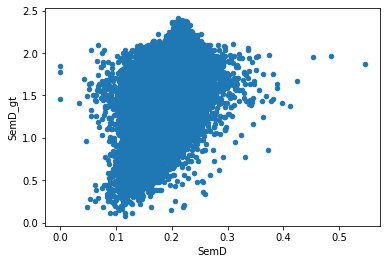

In [6]:
project = 'bnc_w_gt_terms'
gt = gt1
scatterplot(f'../data/out/SemD/{project}', f'{project}.semd', gt)
semd_correlation(f'../data/out/SemD/{project}', f'{project}.semd', gt)

vocab size: 30597
vocab size: 26811
vocab size: 30597
vocab size: 26811


,mean_cos,SemD,mean_cos_gt,SemD_gt
term,,,,
aa,0.613469,0.212207,0.025144,1.599565
aback,0.751403,0.124127,0.056398,1.248734
abacus,0.683831,0.165051,0.053545,1.271280
abandon,0.626641,0.202982,0.013255,1.877634
abandoned,0.629700,0.200866,0.011400,1.943106
...,...,...,...,...
zoology,0.654296,0.184226,0.077217,1.112288
zoom,0.602654,0.219932,0.075840,1.120104
zooming,0.734565,0.133970,0.088965,1.050780


mean_cos    0.298594
SemD        0.321411
Name: correlation, dtype: float64

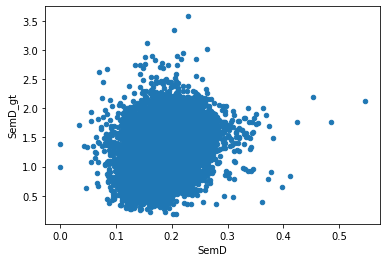

In [7]:
project = 'bnc_w_gt_terms'
gt = gt2
scatterplot(f'../data/out/SemD/{project}', f'{project}.semd', gt)
semd_correlation(f'../data/out/SemD/{project}', f'{project}.semd', gt)

vocab size: 30597
vocab size: 11902
vocab size: 30597
vocab size: 11902


,mean_cos,SemD,mean_cos_gt,SemD_gt,BNC_wordcount,BNC_contexts,BNC_freq,lg_BNC_freq
term,,,,,,,,
aa,0.613469,0.212207,0.020000,1.69,577,314,6.6,0.88
abandon,0.626641,0.202982,0.008199,2.09,1257,1193,14.4,1.19
abandoned,0.629700,0.200866,0.007843,2.11,2931,2684,33.7,1.54
abbey,0.634928,0.197275,0.032021,1.49,1769,1071,20.3,1.33
abbot,0.699511,0.155206,0.085236,1.07,521,343,6.0,0.84
...,...,...,...,...,...,...,...,...
zinc,0.596837,0.224144,0.056128,1.25,422,248,4.9,0.77
zip,0.627465,0.202411,0.062446,1.20,335,223,3.9,0.69
zone,0.619180,0.208183,0.016180,1.79,2510,1551,28.9,1.47


mean_cos         0.600281
SemD             0.598947
BNC_contexts          NaN
BNC_freq              NaN
BNC_wordcount         NaN
lg_BNC_freq           NaN
Name: correlation, dtype: float64

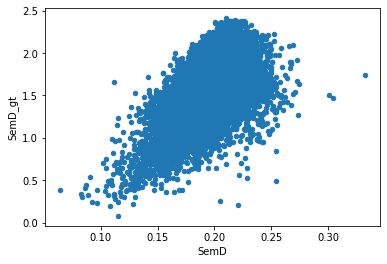

In [8]:
project = 'bnc_w_gt_terms_40'
gt = gt1
scatterplot(f'../data/out/SemD/{project}', f'{project}.semd', gt, min_contexts=40)
semd_correlation(f'../data/out/SemD/{project}', f'{project}.semd', gt, min_contexts=40)

vocab size: 30597
vocab size: 11814
vocab size: 30597
vocab size: 11814


,mean_cos,SemD,mean_cos_gt,SemD_gt
term,,,,
aa,0.613469,0.212207,0.025144,1.599565
abandon,0.626641,0.202982,0.013255,1.877634
abandoned,0.629700,0.200866,0.011400,1.943106
abbey,0.634928,0.197275,0.045762,1.339498
abbot,0.699511,0.155206,0.070183,1.153768
...,...,...,...,...
zinc,0.596837,0.224144,0.080052,1.096631
zip,0.627465,0.202411,0.129050,0.889244
zone,0.619180,0.208183,0.020759,1.682794


mean_cos    0.407721
SemD        0.431348
Name: correlation, dtype: float64

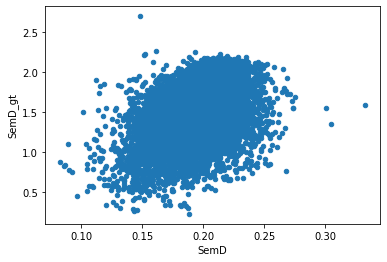

In [9]:
project = 'bnc_w_gt_terms_40'
gt = gt2
scatterplot(f'../data/out/SemD/{project}', f'{project}.semd', gt, min_contexts=40)
semd_correlation(f'../data/out/SemD/{project}', f'{project}.semd', gt, min_contexts=40)

vocab size: 30597
vocab size: 28423
vocab size: 30597
vocab size: 28423


,mean_cos,SemD,nb_contexts,mean_cos_gt,SemD_gt,BNC_wordcount,BNC_contexts,BNC_freq,lg_BNC_freq
term,,,,,,,,,
aa,0.065277,1.185243,77.0,0.020000,1.69,577,314,6.6,0.88
aah,0.193133,0.714143,33.0,0.085245,1.07,92,58,1.1,0.31
aback,0.277250,0.557128,4.0,0.025864,1.59,294,293,3.4,0.64
abacus,0.073892,1.131403,7.0,0.022685,1.64,51,40,0.6,0.20
abandon,0.030345,1.517909,64.0,0.008199,2.09,1257,1193,14.4,1.19
...,...,...,...,...,...,...,...,...,...
zoology,0.193111,0.714192,13.0,0.068300,1.17,115,94,1.3,0.37
zoom,0.113206,0.946130,36.0,0.051591,1.29,241,161,2.8,0.58
zooming,0.322433,0.491560,4.0,0.023874,1.62,61,54,0.7,0.23


mean_cos         0.556321
SemD             0.518423
BNC_contexts          NaN
BNC_freq              NaN
BNC_wordcount         NaN
lg_BNC_freq           NaN
nb_contexts           NaN
Name: correlation, dtype: float64

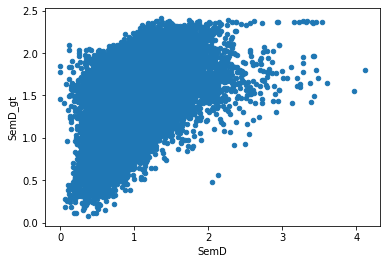

In [10]:
project = 'bnc_w_gt_terms_cent'
gt = gt1
scatterplot(f'../data/out/SemD/{project}', f'{project}.semd', gt)
semd_correlation(f'../data/out/SemD/{project}', f'{project}.semd', gt)

vocab size: 30597
vocab size: 11902
vocab size: 30597
vocab size: 11902


,mean_cos,SemD,nb_contexts,mean_cos_gt,SemD_gt,BNC_wordcount,BNC_contexts,BNC_freq,lg_BNC_freq
term,,,,,,,,,
aa,0.065277,1.185243,77.0,0.020000,1.69,577,314,6.6,0.88
abandon,0.030345,1.517909,64.0,0.008199,2.09,1257,1193,14.4,1.19
abandoned,0.037203,1.429417,189.0,0.007843,2.11,2931,2684,33.7,1.54
abbey,0.060376,1.219139,364.0,0.032021,1.49,1769,1071,20.3,1.33
abbot,0.123277,0.909117,109.0,0.085236,1.07,521,343,6.0,0.84
...,...,...,...,...,...,...,...,...,...
zinc,0.089873,1.046369,66.0,0.056128,1.25,422,248,4.9,0.77
zip,0.104660,0.980220,54.0,0.062446,1.20,335,223,3.9,0.69
zone,0.083912,1.076176,416.0,0.016180,1.79,2510,1551,28.9,1.47


mean_cos         0.665627
SemD             0.617783
BNC_contexts          NaN
BNC_freq              NaN
BNC_wordcount         NaN
lg_BNC_freq           NaN
nb_contexts           NaN
Name: correlation, dtype: float64

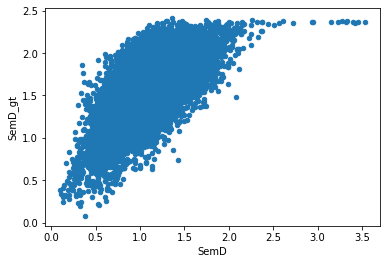

In [11]:
project = 'bnc_w_gt_terms_cent'
gt = gt1
scatterplot(f'../data/out/SemD/{project}', f'{project}.semd', gt, min_contexts=40)
semd_correlation(f'../data/out/SemD/{project}', f'{project}.semd', gt, min_contexts=40)

-----

### Correlation between Correlation BNC-groundtruth => BNC-new/filtered / Gensim-LSI / SemSim-SemD

`bnc_cs1000_lc_filtered` was calculated on the following parameters:

**Korpus:**
- corpus: BNC
- chunk_size: 1000
- min-doc-size: 1
- lowercase: True
- filtered: punct etc.
- #chunks: 

**Term-Document-Matrix:**
- vocab: none
- min-contexts: 40
- min-word-freq: 50
- #terms => 

**Entropy Normalization:**
- epsilon: 1.0
- log base: e

**LSI Projection:**
- dimensions: 300
- implementation: gensim

**SemD calculation:**
- implementation: semsim

**Correlation: 0.43**

vocab size: 30597
vocab size: 30566
vocab size: 30597
vocab size: 30566


,mean_cos,SemD,mean_cos_gt,SemD_gt,BNC_wordcount,BNC_contexts,BNC_freq,lg_BNC_freq
term,,,,,,,,
aa,0.590655,0.228666,0.020000,1.69,577,314,6.6,0.88
aah,0.719699,0.142849,0.085245,1.07,92,58,1.1,0.31
aback,0.720500,0.142366,0.025864,1.59,294,293,3.4,0.64
abacus,0.636651,0.196098,0.022685,1.64,51,40,0.6,0.20
abandon,0.608573,0.215687,0.008199,2.09,1257,1193,14.4,1.19
...,...,...,...,...,...,...,...,...
zoom,0.599449,0.222248,0.051591,1.29,241,161,2.8,0.58
zoomed,0.619235,0.208145,0.029300,1.53,64,59,0.7,0.24
zooming,0.639070,0.194451,0.023874,1.62,61,54,0.7,0.23


mean_cos         0.418355
SemD             0.425845
BNC_contexts          NaN
BNC_freq              NaN
BNC_wordcount         NaN
lg_BNC_freq           NaN
Name: correlation, dtype: float64

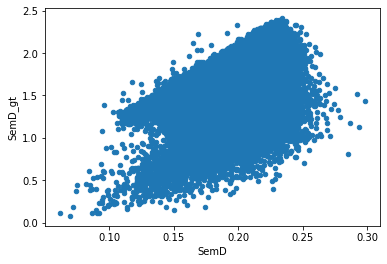

In [12]:
project = 'bnc_cs1000_lc_filtered'
gt = gt1
scatterplot(f'../data/out/SemD/{project}', f'{project}.semd', gt)
semd_correlation(f'../data/out/SemD/{project}', f'{project}.semd', gt)

vocab size: 30597
vocab size: 27371
vocab size: 30597
vocab size: 27371


,mean_cos,SemD,mean_cos_gt,SemD_gt
term,,,,
aa,0.590655,0.228666,0.025144,1.599565
aback,0.720500,0.142366,0.056398,1.248734
abacus,0.636651,0.196098,0.053545,1.271280
abandon,0.608573,0.215687,0.013255,1.877634
abandoned,0.609739,0.214856,0.011400,1.943106
...,...,...,...,...
zoology,0.639991,0.193826,0.077217,1.112288
zoom,0.599449,0.222248,0.075840,1.120104
zooming,0.639070,0.194451,0.088965,1.050780


mean_cos    0.226680
SemD        0.233791
Name: correlation, dtype: float64

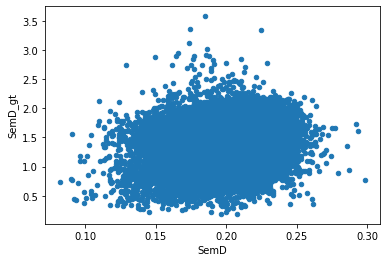

In [13]:
project = 'bnc_cs1000_lc_filtered'
gt = gt2
scatterplot(f'../data/out/SemD/{project}', f'{project}.semd', gt)
semd_correlation(f'../data/out/SemD/{project}', f'{project}.semd', gt)

vocab size: 30597
vocab size: 30513
vocab size: 30597
vocab size: 30513


,mean_cos,SemD,mean_cos_gt,SemD_gt,BNC_wordcount,BNC_contexts,BNC_freq,lg_BNC_freq
term,,,,,,,,
aa,0.590655,0.228666,0.020000,1.69,577,314,6.6,0.88
aah,0.719699,0.142849,0.085245,1.07,92,58,1.1,0.31
aback,0.720500,0.142366,0.025864,1.59,294,293,3.4,0.64
abacus,0.636651,0.196098,0.022685,1.64,51,40,0.6,0.20
abandon,0.608573,0.215687,0.008199,2.09,1257,1193,14.4,1.19
...,...,...,...,...,...,...,...,...
zoom,0.599449,0.222248,0.051591,1.29,241,161,2.8,0.58
zoomed,0.619235,0.208145,0.029300,1.53,64,59,0.7,0.24
zooming,0.639070,0.194451,0.023874,1.62,61,54,0.7,0.23


mean_cos         0.414279
SemD             0.423435
BNC_contexts          NaN
BNC_freq              NaN
BNC_wordcount         NaN
lg_BNC_freq           NaN
Name: correlation, dtype: float64

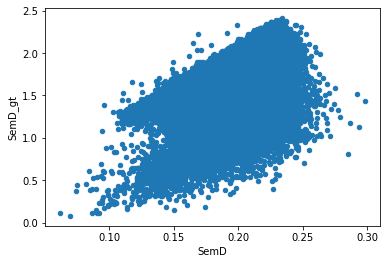

In [14]:
project = 'bnc_cs1000_lc_filtered_40'
gt = gt1
scatterplot(f'../data/out/SemD/{project}', f'{project}.semd', gt, min_contexts=40)
semd_correlation(f'../data/out/SemD/{project}', f'{project}.semd', gt, min_contexts=40)

vocab size: 30597
vocab size: 27338
vocab size: 30597
vocab size: 27338


,mean_cos,SemD,mean_cos_gt,SemD_gt
term,,,,
aa,0.590655,0.228666,0.025144,1.599565
aback,0.720500,0.142366,0.056398,1.248734
abacus,0.636651,0.196098,0.053545,1.271280
abandon,0.608573,0.215687,0.013255,1.877634
abandoned,0.609739,0.214856,0.011400,1.943106
...,...,...,...,...
zoology,0.639991,0.193826,0.077217,1.112288
zoom,0.599449,0.222248,0.075840,1.120104
zooming,0.639070,0.194451,0.088965,1.050780


mean_cos    0.225842
SemD        0.233060
Name: correlation, dtype: float64

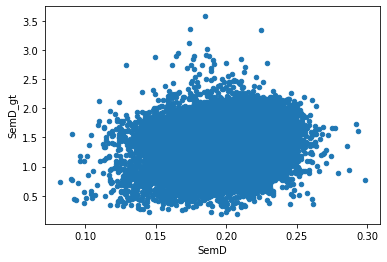

In [15]:
project = 'bnc_cs1000_lc_filtered_40'
gt = gt2
scatterplot(f'../data/out/SemD/{project}', f'{project}.semd', gt, min_contexts=40)
semd_correlation(f'../data/out/SemD/{project}', f'{project}.semd', gt, min_contexts=40)

----

### Correlation BNC-groundtruth => BNC-new / gensim-LSI / SemSim-SemD

`bnc_cs1000_minsz100_lc_natlog` was calculated on the following parameters:

**Korpus:**
- corpus: BNC
- chunk_size: 1000
- min-doc-size: 100
- lowercase: True
- filtered: none
- #chunks: 

**Term-Document-Matrix:**
- vocab: none
- min-contexts: 40
- min-word-freq: 50
- #terms => 42067

**Entropy Normalization:**
- epsilon: 0.0
- log base: e

**LSI Projection:**
- dimensions: 300
- implementation: gensim

**SemD calculation:**
- implementation: semsim

**Correlation: 0.44**

vocab size: 30597
vocab size: 29518
vocab size: 30597
vocab size: 29518


,mean_cos,SemD,nb_contexts,mean_cos_gt,SemD_gt,BNC_wordcount,BNC_contexts,BNC_freq,lg_BNC_freq
term,,,,,,,,,
aa,0.658565,0.181401,77.0,0.020000,1.69,577,314,6.6,0.88
aah,0.697880,0.156219,33.0,0.085245,1.07,92,58,1.1,0.31
aback,0.773061,0.111786,4.0,0.025864,1.59,294,293,3.4,0.64
abacus,0.714109,0.146236,7.0,0.022685,1.64,51,40,0.6,0.20
abandon,0.656738,0.182608,64.0,0.008199,2.09,1257,1193,14.4,1.19
...,...,...,...,...,...,...,...,...,...
zoom,0.627375,0.202473,36.0,0.051591,1.29,241,161,2.8,0.58
zoomed,0.669671,0.174139,3.0,0.029300,1.53,64,59,0.7,0.24
zooming,0.751755,0.123924,4.0,0.023874,1.62,61,54,0.7,0.23


mean_cos         0.427998
SemD             0.439538
BNC_contexts          NaN
BNC_freq              NaN
BNC_wordcount         NaN
lg_BNC_freq           NaN
nb_contexts           NaN
Name: correlation, dtype: float64

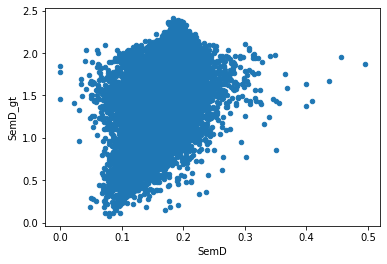

In [16]:
project = 'bnc_cs1000_minsz100_lc_natlog_100'
gt = gt1
scatterplot(f'../data/out/SemD/{project}', f'{project}.semd', gt, min_contexts=2)
semd_correlation(f'../data/out/SemD/{project}', f'{project}.semd', gt, min_contexts=2)

vocab size: 30597
vocab size: 26811
vocab size: 30597
vocab size: 26811


,mean_cos,SemD,nb_contexts,mean_cos_gt,SemD_gt
term,,,,,
aa,0.658565,0.181401,77.0,0.025144,1.599565
aback,0.773061,0.111786,4.0,0.056398,1.248734
abacus,0.714109,0.146236,7.0,0.053545,1.271280
abandon,0.656738,0.182608,64.0,0.013255,1.877634
abandoned,0.670515,0.173592,189.0,0.011400,1.943106
...,...,...,...,...,...
zoology,0.693723,0.158814,13.0,0.077217,1.112288
zoom,0.627375,0.202473,36.0,0.075840,1.120104
zooming,0.751755,0.123924,4.0,0.088965,1.050780


mean_cos       0.271256
SemD           0.296325
nb_contexts         NaN
Name: correlation, dtype: float64

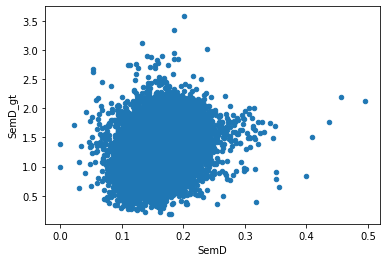

In [17]:
project = 'bnc_cs1000_minsz100_lc_natlog_100'
gt = gt2
scatterplot(f'../data/out/SemD/{project}', f'{project}.semd', gt, min_contexts=2)
semd_correlation(f'../data/out/SemD/{project}', f'{project}.semd', gt, min_contexts=2)

vocab size: 30597
vocab size: 11902
vocab size: 30597
vocab size: 11902


,mean_cos,SemD,nb_contexts,mean_cos_gt,SemD_gt,BNC_wordcount,BNC_contexts,BNC_freq,lg_BNC_freq
term,,,,,,,,,
aa,0.658565,0.181401,77.0,0.020000,1.69,577,314,6.6,0.88
abandon,0.656738,0.182608,64.0,0.008199,2.09,1257,1193,14.4,1.19
abandoned,0.670515,0.173592,189.0,0.007843,2.11,2931,2684,33.7,1.54
abbey,0.676795,0.169543,364.0,0.032021,1.49,1769,1071,20.3,1.33
abbot,0.722202,0.141341,109.0,0.085236,1.07,521,343,6.0,0.84
...,...,...,...,...,...,...,...,...,...
zinc,0.633692,0.198122,66.0,0.056128,1.25,422,248,4.9,0.77
zip,0.670418,0.173655,54.0,0.062446,1.20,335,223,3.9,0.69
zone,0.650441,0.186792,416.0,0.016180,1.79,2510,1551,28.9,1.47


mean_cos         0.560097
SemD             0.569579
BNC_contexts          NaN
BNC_freq              NaN
BNC_wordcount         NaN
lg_BNC_freq           NaN
nb_contexts           NaN
Name: correlation, dtype: float64

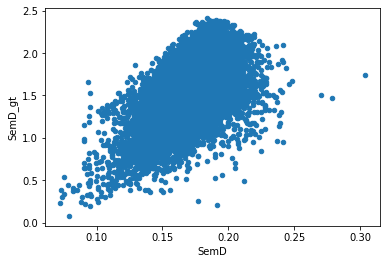

In [18]:
project = 'bnc_cs1000_minsz100_lc_natlog_100'
gt = gt1
scatterplot(f'../data/out/SemD/{project}', f'{project}.semd', gt, min_contexts=40)
semd_correlation(f'../data/out/SemD/{project}', f'{project}.semd', gt, min_contexts=40)

vocab size: 30597
vocab size: 11814
vocab size: 30597
vocab size: 11814


,mean_cos,SemD,nb_contexts,mean_cos_gt,SemD_gt
term,,,,,
aa,0.658565,0.181401,77.0,0.025144,1.599565
abandon,0.656738,0.182608,64.0,0.013255,1.877634
abandoned,0.670515,0.173592,189.0,0.011400,1.943106
abbey,0.676795,0.169543,364.0,0.045762,1.339498
abbot,0.722202,0.141341,109.0,0.070183,1.153768
...,...,...,...,...,...
zinc,0.633692,0.198122,66.0,0.080052,1.096631
zip,0.670418,0.173655,54.0,0.129050,0.889244
zone,0.650441,0.186792,416.0,0.020759,1.682794


mean_cos       0.364783
SemD           0.393621
nb_contexts         NaN
Name: correlation, dtype: float64

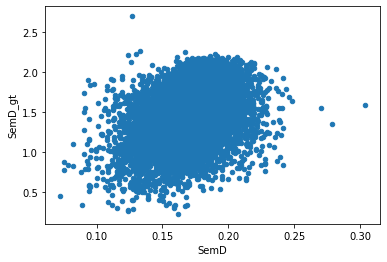

In [19]:
project = 'bnc_cs1000_minsz100_lc_natlog_100'
gt = gt2
scatterplot(f'../data/out/SemD/{project}', f'{project}.semd', gt, min_contexts=40)
semd_correlation(f'../data/out/SemD/{project}', f'{project}.semd', gt, min_contexts=40)

vocab size: 30597
vocab size: 7188
vocab size: 30597
vocab size: 7188


,mean_cos,SemD,nb_contexts,mean_cos_gt,SemD_gt,BNC_wordcount,BNC_contexts,BNC_freq,lg_BNC_freq
term,,,,,,,,,
abandoned,0.670515,0.173592,189.0,0.007843,2.11,2931,2684,33.7,1.54
abbey,0.676795,0.169543,364.0,0.032021,1.49,1769,1071,20.3,1.33
abbot,0.722202,0.141341,109.0,0.085236,1.07,521,343,6.0,0.84
abdominal,0.672205,0.172498,101.0,0.082626,1.08,536,309,6.2,0.85
abilities,0.676477,0.169747,141.0,0.019100,1.72,1272,1051,14.6,1.19
...,...,...,...,...,...,...,...,...,...
zero,0.642508,0.192122,385.0,0.027248,1.56,2249,1477,25.9,1.43
zimbabwe,0.676557,0.169696,124.0,0.056814,1.25,585,385,6.7,0.89
zone,0.650441,0.186792,416.0,0.016180,1.79,2510,1551,28.9,1.47


mean_cos         0.532618
SemD             0.535491
BNC_contexts          NaN
BNC_freq              NaN
BNC_wordcount         NaN
lg_BNC_freq           NaN
nb_contexts           NaN
Name: correlation, dtype: float64

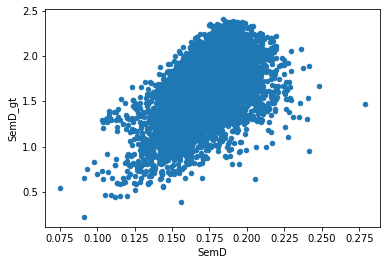

In [20]:
project = 'bnc_cs1000_minsz100_lc_natlog_100'
gt = gt1
scatterplot(f'../data/out/SemD/{project}', f'{project}.semd', gt, min_contexts=100)
semd_correlation(f'../data/out/SemD/{project}', f'{project}.semd', gt, min_contexts=100)

vocab size: 30597
vocab size: 30597
vocab size: 30597
vocab size: 30597


,mean_cos,SemD,nb_contexts,mean_cos_gt,SemD_gt,BNC_wordcount,BNC_contexts,BNC_freq,lg_BNC_freq
term,,,,,,,,,
aa,0.057682,1.238958,268.0,0.020000,1.69,577,314,6.6,0.88
aah,0.178663,0.747966,127.0,0.085245,1.07,92,58,1.1,0.31
aback,0.126732,0.897113,299.0,0.025864,1.59,294,293,3.4,0.64
abacus,0.036755,1.434684,42.0,0.022685,1.64,51,40,0.6,0.20
abandon,0.017703,1.751949,1226.0,0.008199,2.09,1257,1193,14.4,1.19
...,...,...,...,...,...,...,...,...,...
zoom,0.081184,1.090532,176.0,0.051591,1.29,241,161,2.8,0.58
zoomed,0.043571,1.360798,62.0,0.029300,1.53,64,59,0.7,0.24
zooming,0.039183,1.406907,62.0,0.023874,1.62,61,54,0.7,0.23


mean_cos         0.880323
SemD             0.867904
BNC_contexts          NaN
BNC_freq              NaN
BNC_wordcount         NaN
lg_BNC_freq           NaN
nb_contexts           NaN
Name: correlation, dtype: float64

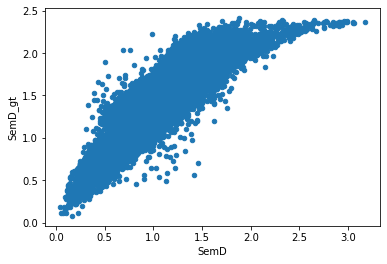

In [22]:
project = 'bnc_cs1000_minsz50_lc_tfidf'
gt = gt1
scatterplot(f'../data/out/SemD/{project}', f'{project}.semd', gt, min_contexts=40)
semd_correlation(f'../data/out/SemD/{project}', f'{project}.semd', gt, min_contexts=40)

vocab size: 30597
vocab size: 30597
vocab size: 30597
vocab size: 30597


,mean_cos,SemD,nb_contexts,mean_cos_gt,SemD_gt,BNC_wordcount,BNC_contexts,BNC_freq,lg_BNC_freq
term,,,,,,,,,
aa,0.061997,1.207626,268.0,0.020000,1.69,577,314,6.6,0.88
aah,0.235341,0.628303,127.0,0.085245,1.07,92,58,1.1,0.31
aback,0.139560,0.855239,299.0,0.025864,1.59,294,293,3.4,0.64
abacus,0.043847,1.358057,42.0,0.022685,1.64,51,40,0.6,0.20
abandon,0.020303,1.692430,1226.0,0.008199,2.09,1257,1193,14.4,1.19
...,...,...,...,...,...,...,...,...,...
zoom,0.086550,1.062733,176.0,0.051591,1.29,241,161,2.8,0.58
zoomed,0.062499,1.204128,62.0,0.029300,1.53,64,59,0.7,0.24
zooming,0.049495,1.305440,62.0,0.023874,1.62,61,54,0.7,0.23


mean_cos         0.876805
SemD             0.867193
BNC_contexts          NaN
BNC_freq              NaN
BNC_wordcount         NaN
lg_BNC_freq           NaN
nb_contexts           NaN
Name: correlation, dtype: float64

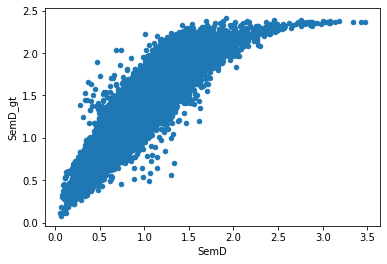

In [33]:
project = 'bnc_cs1000_minsz50_lc_logentropynorm_cent'
gt = gt1
scatterplot(f'../data/out/SemD/{project}', f'{project}.semd', gt, min_contexts=2, remove_outlier=False)
semd_correlation(f'../data/out/SemD/{project}', f'{project}.semd', gt, min_contexts=2, remove_outlier=False)

vocab size: 30597
vocab size: 30597
vocab size: 30597
vocab size: 30597


,mean_cos,SemD,nb_contexts,mean_cos_gt,SemD_gt,BNC_wordcount,BNC_contexts,BNC_freq,lg_BNC_freq
term,,,,,,,,,
aa,0.267329,0.572955,268.0,0.020000,1.69,577,314,6.6,0.88
aah,0.443071,0.353527,127.0,0.085245,1.07,92,58,1.1,0.31
aback,0.420101,0.376646,299.0,0.025864,1.59,294,293,3.4,0.64
abacus,0.321725,0.492516,42.0,0.022685,1.64,51,40,0.6,0.20
abandon,0.256954,0.590145,1226.0,0.008199,2.09,1257,1193,14.4,1.19
...,...,...,...,...,...,...,...,...,...
zoom,0.297354,0.526727,176.0,0.051591,1.29,241,161,2.8,0.58
zoomed,0.301274,0.521039,62.0,0.029300,1.53,64,59,0.7,0.24
zooming,0.320701,0.493900,62.0,0.023874,1.62,61,54,0.7,0.23


mean_cos         0.751777
SemD             0.740216
BNC_contexts          NaN
BNC_freq              NaN
BNC_wordcount         NaN
lg_BNC_freq           NaN
nb_contexts           NaN
Name: correlation, dtype: float64

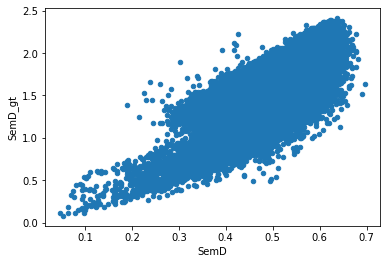

In [32]:
project = 'bnc_cs1000_minsz50_lc_logentropynorm'
gt = gt1
scatterplot(f'../data/out/SemD/{project}', f'{project}.semd', gt, min_contexts=2, remove_outlier=False)
semd_correlation(f'../data/out/SemD/{project}', f'{project}.semd', gt, min_contexts=2, remove_outlier=False)

vocab size: 30597
vocab size: 30597
vocab size: 30597
vocab size: 30597


,mean_cos,SemD,nb_contexts,mean_cos_gt,SemD_gt,BNC_wordcount,BNC_contexts,BNC_freq,lg_BNC_freq
term,,,,,,,,,
aa,0.048213,1.316840,268.0,0.020000,1.69,577,314,6.6,0.88
aah,0.264442,0.577670,127.0,0.085245,1.07,92,58,1.1,0.31
aback,0.173880,0.759751,299.0,0.025864,1.59,294,293,3.4,0.64
abacus,0.040915,1.388113,42.0,0.022685,1.64,51,40,0.6,0.20
abandon,0.015527,1.808901,1226.0,0.008199,2.09,1257,1193,14.4,1.19
...,...,...,...,...,...,...,...,...,...
zoom,0.085328,1.068907,176.0,0.051591,1.29,241,161,2.8,0.58
zoomed,0.070392,1.152477,62.0,0.029300,1.53,64,59,0.7,0.24
zooming,0.060091,1.221193,62.0,0.023874,1.62,61,54,0.7,0.23


mean_cos         0.840468
SemD             0.857283
BNC_contexts          NaN
BNC_freq              NaN
BNC_wordcount         NaN
lg_BNC_freq           NaN
nb_contexts           NaN
Name: correlation, dtype: float64

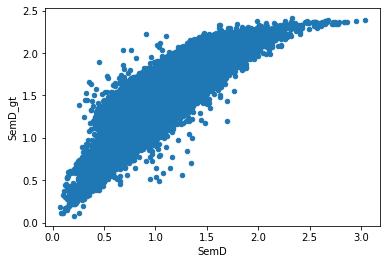

In [31]:
project = 'bnc_cs1000_minsz50_lc_logentropy'
gt = gt1
scatterplot(f'../data/out/SemD/{project}', f'{project}.semd', gt, min_contexts=2, remove_outlier=False)
semd_correlation(f'../data/out/SemD/{project}', f'{project}.semd', gt, min_contexts=2, remove_outlier=False)

vocab size: 30597
vocab size: 30597
vocab size: 30597
vocab size: 30597


,mean_cos,SemD,nb_contexts,mean_cos_gt,SemD_gt,BNC_wordcount,BNC_contexts,BNC_freq,lg_BNC_freq
term,,,,,,,,,
aa,0.054299,1.265207,268.0,0.020000,1.69,577,314,6.6,0.88
aah,0.219134,0.659290,127.0,0.085245,1.07,92,58,1.1,0.31
aback,0.145738,0.836426,299.0,0.025864,1.59,294,293,3.4,0.64
abacus,0.040604,1.391427,42.0,0.022685,1.64,51,40,0.6,0.20
abandon,0.018604,1.730397,1226.0,0.008199,2.09,1257,1193,14.4,1.19
...,...,...,...,...,...,...,...,...,...
zoom,0.085657,1.067238,176.0,0.051591,1.29,241,161,2.8,0.58
zoomed,0.064375,1.191284,62.0,0.029300,1.53,64,59,0.7,0.24
zooming,0.049129,1.308662,62.0,0.023874,1.62,61,54,0.7,0.23


mean_cos         0.863550
SemD             0.864698
BNC_contexts          NaN
BNC_freq              NaN
BNC_wordcount         NaN
lg_BNC_freq           NaN
nb_contexts           NaN
Name: correlation, dtype: float64

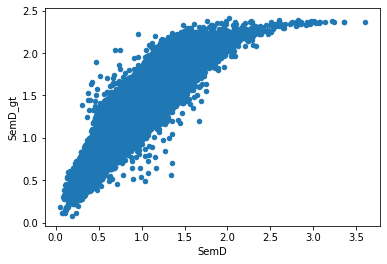

In [30]:
project = 'bnc_cs1000_minsz50_lc_logentropy_norm'
gt = gt1
scatterplot(f'../data/out/SemD/{project}', f'{project}.semd', gt, min_contexts=2, remove_outlier=False)
semd_correlation(f'../data/out/SemD/{project}', f'{project}.semd', gt, min_contexts=2, remove_outlier=False)

vocab size: 30597
vocab size: 30597
vocab size: 30597
vocab size: 30597


,mean_cos,SemD,nb_contexts,mean_cos_gt,SemD_gt,BNC_wordcount,BNC_contexts,BNC_freq,lg_BNC_freq
term,,,,,,,,,
aa,0.054299,1.265207,268.0,0.020000,1.69,577,314,6.6,0.88
aah,0.219134,0.659290,127.0,0.085245,1.07,92,58,1.1,0.31
aback,0.145738,0.836426,299.0,0.025864,1.59,294,293,3.4,0.64
abacus,0.040604,1.391427,42.0,0.022685,1.64,51,40,0.6,0.20
abandon,0.018604,1.730397,1226.0,0.008199,2.09,1257,1193,14.4,1.19
...,...,...,...,...,...,...,...,...,...
zoom,0.085657,1.067238,176.0,0.051591,1.29,241,161,2.8,0.58
zoomed,0.064375,1.191284,62.0,0.029300,1.53,64,59,0.7,0.24
zooming,0.049129,1.308662,62.0,0.023874,1.62,61,54,0.7,0.23


mean_cos         0.863550
SemD             0.864698
BNC_contexts          NaN
BNC_freq              NaN
BNC_wordcount         NaN
lg_BNC_freq           NaN
nb_contexts           NaN
Name: correlation, dtype: float64

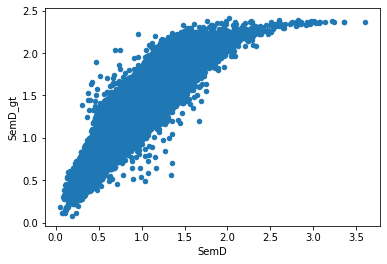

In [29]:
project = 'bnc_cs1000_minsz50_lc_logentropy_cent'
gt = gt1
scatterplot(f'../data/out/SemD/{project}', f'{project}.semd', gt, min_contexts=2, remove_outlier=False)
semd_correlation(f'../data/out/SemD/{project}', f'{project}.semd', gt, min_contexts=2, remove_outlier=False)

----

### Correlation BNC-groundtruth => Hoffman Test-Data

Hoffman's test data was calculated on the following parameters:

**Korpus:**
- corpus: ?
- chunk_size: ?
- min-doc-size: ?
- lowercase: True
- filtered: ?
- #chunks: 112799

**Term-Document-Matrix:**
- vocab: none
- min-contexts: ?
- min-word-freq: ?
- #terms: 74100

**Entropy Normalization:**
- epsilon: ?
- log base: ?

**LSI Projection:**
- dimensions: 300
- implementation: GTP

**SemD calculation:**
- implementation: **hoffman**

**Correlation: 0.71**

In [ ]:
dirpath = '../tmp/Psycho-Paper/semD'
file = 'semd_test_values.csv'

gt = gt1
scatterplot(dirpath, file, gt, min_contexts=2)
semd_correlation(dirpath, file, gt, min_contexts=2)

----

### Correlation BNC-groundtruth => Hoffman Test-Data w/ sklearn LSI

Hoffman's test data was calculated on the following parameters:

**Korpus:**
- corpus: ?
- chunk_size: ?
- min-doc-size: ?
- lowercase: True
- filtered: ?
- #chunks: 112799

**Term-Document-Matrix:**
- vocab: none
- min-contexts: ?
- min-word-freq: ?
- #terms: 74100

**Entropy Normalization:**
- epsilon: ?
- log base: ?

**LSI Projection:**
- dimensions: 300
- implementation: sklearn

**SemD calculation:**
- implementation: **hoffman**

**Correlation: ...**

In [ ]:
project = 'hoffman_V_sklearn'
gt = gt1
scatterplot(f'../data/out/SemD/{project}', f'{project}.semd', gt)
semd_correlation(f'../data/out/SemD/{project}', f'{project}.semd', gt)

In [ ]:
project = 'hoffman_V_sklearn'
gt = gt2
scatterplot(f'../data/out/SemD/{project}', f'{project}.semd', gt)
semd_correlation(f'../data/out/SemD/{project}', f'{project}.semd', gt)

----

### Correlation BNC-groundtruth => Hoffman Test-Data w/ centered sklearn LSI

Hoffman's test data was calculated on the following parameters:

**Korpus:**
- corpus: ?
- chunk_size: ?
- min-doc-size: ?
- lowercase: True
- filtered: ?
- #chunks: 112799

**Term-Document-Matrix:**
- vocab: none
- min-contexts: ?
- min-word-freq: ?
- #terms: 74100

**Entropy Normalization:**
- epsilon: ?
- log base: ?

**LSI Projection:**
- dimensions: 300
- implementation: sklearn/centered

**SemD calculation:**
- implementation: **hoffman**

**Correlation: ...**

In [ ]:
project = 'hoffman_V_sklearn_cent'
gt = gt1
scatterplot(f'../data/out/SemD/{project}', f'{project}.semd', gt)
semd_correlation(f'../data/out/SemD/{project}', f'{project}.semd', gt)

In [ ]:
project = 'hoffman_V_sklearn_cent'
gt = gt2
scatterplot(f'../data/out/SemD/{project}', f'{project}.semd', gt)
semd_correlation(f'../data/out/SemD/{project}', f'{project}.semd', gt)

Finding: centering the data reduces SemD correlation

-----

### Vefrifying updated semsim-SemD calculation against Hoffman's reference implementation

In [ ]:
semd_correlation(
    '../tmp/Psycho-Paper/semD',
    'gt_terms_w_V.semd',
    gt2,
)

Finding: identical, except for random sampling jitter

----

### Fragen:

- Was ist der Unterschied der Implementierungen: Hoffmann vs Funke? -> resolved
- Warum ist die Korrelation unterschiedlich?
- Kann die Randomisierung eine Rolle spielen?
- Warum ist die Vocab-Größe unterschiedlich? -> Frage unklar
- Sind die NaN values korrekt?